In [1]:
# !pip install --no-cache-dir git+https://github.com/averinpa/bnm.git@feature/sid-metric

# Strictiral Intervention Distance

In [59]:
from bnm import BNMetrics, generate_random_dag
import networkx as nx
import pandas as pd
import plotly.io as pio
pio.renderers.default = 'jupyterlab'
import numpy as np
from causallearn.search.ConstraintBased.PC import pc

# Introduction

Evaluating the accuracy of estimated causal graphs is essential in causal inference, particularly when the goal is to predict the outcomes of interventions. Common metrics such as the **Structural Hamming Distance (SHD)** only capture edge-level discrepancies between graphs and do not reflect whether those differences affect **causal predictions**.

To address this limitation, **Peters and Bühlmann (2014)** introduced the **Structural Intervention Distance (SID)** — a graph-based metric designed to measure how many interventional distributions are incorrectly estimated by a given graph structure. Unlike SHD, SID is **semantically grounded**: it quantifies how many pairs of nodes $(i, j)$ have incorrect causal effect estimates $p(X_j \mid do(X_i))$ in the estimated graph, assuming the true data-generating structure is known.

> The methodology and algorithms used for SID in this notebook follow the definitions and procedures introduced in:  
> **Peters, J., & Bühlmann, P. (2014). Structural intervention distance (SID) for evaluating causal graphs.**  
> The implementation is adapted from the corresponding **R package `SID`**, developed by the authors of the original paper.

The SID functionality in the Python `bnmetrics` package is a direct port of this logic, reproducing:
- SID calculation for DAG-to-DAG and DAG-to-CPDAG comparisons
- Lower and upper bounds for CPDAG comparisons  
- Matrix with incorrect causal effects

This notebook presents three use cases for the `sid()` method in `bnmetrics`:
- Use Case 1: Reproducing the Paper Example with G, H₁, and H₂
- Use Case 2: Comparing a DAG with DAGs and a CPDAG (Bounds)
- Use Case 3: SID on Markov Blankets of Selected Nodes


## Use Case 1: Reproducing the SID Paper Example — G vs. H₁ and G vs. H₂

In this example, we replicate the illustrative case from the original SID paper by Peters and Bühlmann (2014), Section 2.1. This example demonstrates that even when two estimated graphs have the **same SHD**, they can differ drastically in how well they **preserve the interventional distributions** implied by the true graph.

---

- $G$: the true DAG  
- $H_1$: adds an extra edge $Y_1 \rightarrow Y_2$, which does not alter any interventional distributions
- $H_2$: has a reversed edge $X_1 \leftarrow X_2$, which does impact interventional predictions


In [60]:
nodes = ['X1', 'X2', 'Y1', 'Y2', 'Y3']

G = np.array([[0, 1, 1, 1, 1], 
             [0, 0, 1, 1, 1], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0]])

H1 = np.array([[0, 1, 1, 1, 1], 
             [0, 0, 1, 1, 1], 
             [0, 0, 0, 1, 0], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0]])

H2 = np.array([[0, 0, 1, 1, 1], 
             [1, 0, 1, 1, 1], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0], 
             [0, 0, 0, 0, 0]])

### Case 1: G vs. H₁
Below are `G` and `H1` side by side. You can see that in `H1` there is an additional edge  $Y_1 \rightarrow Y_2$

In [61]:
bnm = BNMetrics(G, H1, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='G', name2='H1')

In [62]:
(bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'}))

,metric,metric_value
0,shd,1
1,sid,0.0
2,sid_lower_bound,0.0
3,sid_upper_bound,0.0


**Key observations:**
- $\text{SHD}(G, H_1) = 1$  
- $\text{SID}(G, H_1) = 0$  
- The added edge does not introduce bias under any intervention  

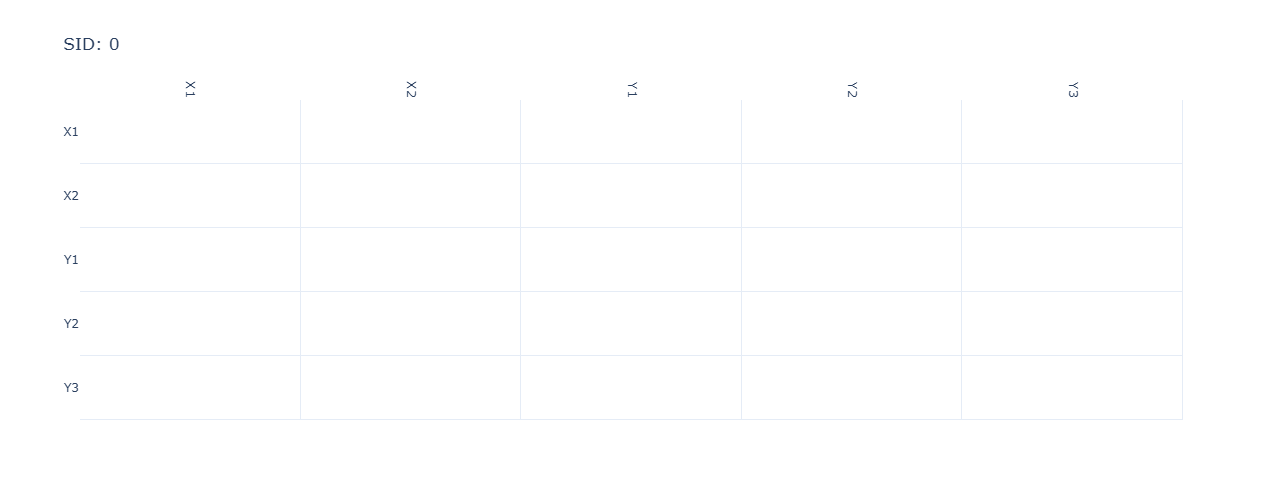

In [63]:
bnm.plot_sid_matrix()

All entries in the SID matrix are 0. All pairs $(i, j)$ have correct interventional predictions

**Conclusion**:  
This shows that SID can be 0 even when SHD is not 0, because SHD penalizes the extra edge even though it has no interventional effect.

---

### Case 2: G vs. H₂

Below are $G$ and $H_2$ side by side. You can see that in $H_2$ there is reversed edge $X_1 \leftarrow X_2$

In [64]:
bnm = BNMetrics(G, H2, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='G', name2='H2')

In [65]:
(bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'}))

,metric,metric_value
0,shd,1
1,sid,8.0
2,sid_lower_bound,8.0
3,sid_upper_bound,8.0


**Key observations:**
- $\text{SHD}(G, H₂) = 1$  
- $\text{SID}(G, H₂) = 8$  
- The reversed edge breaks multiple parent sets used for adjustment
- The SID matrix clearly shows incorrect interventional distributions for several pairs

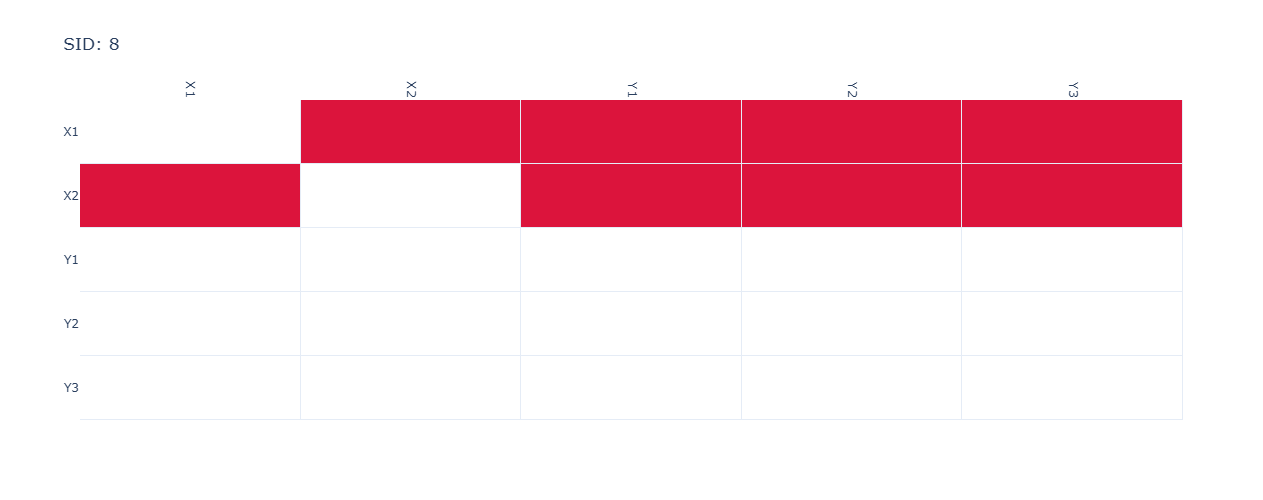

In [66]:
bnm.plot_sid_matrix()

**Conclusion**:  
This example shows that two graphs can have equal $\text{SHD}$ but different $\text{SID}$, highlighting how $\text{SID}$ captures incorrect causal effects rather than structural mismatches alone.

## Use Case 2: Comparing DAG with DAGs and CPDAG — SID Bounds

In this example, we illustrate how the $\text{SID}$ behaves when comparing a true DAG to:
- multiple estimated DAGs within a Markov equivalence class
- their corresponding CPDAG (Completed Partially Directed Acyclic Graph)

This use case demonstrates how $\text{SID}$ can be used to compute lower and upper bounds when the estimated structure is partially undirected.

We use the same true DAG in all comparisons, but vary the estimated structures.


### Description of Generated Graphs

The following four graphs are defined over the node set $[X_1, X_2, X_3, X_4]$, and will be used to demonstrate the behavior of SID in both DAG-to-DAG and DAG-to-CPDAG comparisons:

- **DAG**: This graph represents the ground truth from which intervention distributions will be computed.

- **DAG1**: An estimated DAG with structural errors.  
 
- **DAG2**: Another estimated DAG, Markov equivalent to **DAG1**

- **CPDAG**: The completed partially directed acyclic graph representing the Markov equivalence class of DAG1 and DAG2.  
  - It contains both directed and undirected edges indicating uncertainty in edge orientation.  
  - SID lower and upper bounds are computed based on all DAGs consistent with this CPDAG.

These structures serve as a controlled illustration of how SID captures interventional discrepancies, while SHD cannot distinguish between equally distant graphs with different causal implications.


In [67]:
nodes = ['X1', 'X2', 'X3', 'X4']

DAG = np.array([[0, 0, 0, 0], 
                [0, 0, 1, 0], 
                [1, 0, 0, 0], 
                [1, 0, 1, 0]])

DAG1 = np.array([[0, 1, 0, 0], 
                 [0, 0, 1, 0], 
                 [0, 0, 0, 0], 
                 [0, 0, 1, 0]])

DAG2 = np.array([[0, 0, 0, 0], 
                 [1, 0, 1, 0], 
                 [0, 0, 0, 0], 
                 [0, 0, 1, 0]])

CPDAG = np.array([[0, 1, 0, 0], 
                  [1, 0, 1, 0], 
                  [0, 0, 0, 0], 
                  [0, 0, 1, 0]])

### Comparison 1: True DAG vs. Estimated DAG 1

In [68]:
bnm = BNMetrics(DAG, DAG1, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='True DAG', name2='Estimated DAG 1')
print((bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'})))
print('\nSID Incorrect Causal Effects')
print(bnm.sid(nodes=['All'], output=False)['incorrect_mat'])

            metric metric_value
0              shd            3
1              sid          6.0
2  sid_lower_bound          6.0
3  sid_upper_bound          6.0

SID Incorrect Causal Effects
[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]



- $\text{SHD} = 3$
- $\text{SID} = 6$
- SID matrix shows multiple incorrect causal effects, especially for interventions on $X_1$ and $X_2$

### Comparison 2: True DAG vs. Estimated DAG 2

In [69]:
bnm = BNMetrics(DAG, DAG2, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='True DAG', name2='Estimated DAG 2')
print((bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'})))
print('\nSID Incorrect Causal Effects')
print(bnm.sid(nodes=['All'], output=False)['incorrect_mat'])

            metric metric_value
0              shd            3
1              sid          2.0
2  sid_lower_bound          2.0
3  sid_upper_bound          2.0

SID Incorrect Causal Effects
[[0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


- $\text{SHD} = 3$
- $\text{SID} = 2$  
- Fewer incorrect interventions than DAG 1

### Comparison 3: True DAG vs. Estimated CPDAG

In [70]:
bnm = BNMetrics(DAG, CPDAG, node_names=nodes)
bnm.compare_two_bn(nodes=['All'], name1='True DAG', name2='Estimated CPDAG')
print((bnm.compare_df(descriptive_metrics='', comparison_metrics=['shd', 'sid'])
       .query("node_name == 'All'")
       .drop(columns='node_name')
       .T
       .reset_index()
       .rename(columns={0:'metric_value', 'index': 'metric'})))
print('\nSID Incorrect Causal Effects')
print(bnm.sid(nodes=['All'], output=False)['incorrect_mat'])

            metric metric_value
0              shd            3
1              sid          6.0
2  sid_lower_bound          2.0
3  sid_upper_bound          6.0

SID Incorrect Causal Effects
[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]



- $\text{SHD} = 3$
- $\text{SID} = 6$  
- $\text{SID lower bound} = 2$
- $\text{SID upper bound} = 6$

The CPDAG represents the **Markov equivalence class** of DAGs like DAG 1 and DAG 2.  
SID bounds capture the range of possible SID values depending on which DAG in the class we choose.


### Conclusion

| Comparison                 | SHD | SID  | SID Lower | SID Upper |
|----------------------------|-----|------|-----------|-----------|
| DAG vs. DAG 1              |  3  | 6.0  |     –     |     –     |
| DAG vs. DAG 2              |  3  | 2.0  |     –     |     –     |
| DAG vs. CPDAG (DAG1+2 mix) |  3  | 6.0  |   2.0     |   6.0     |

This example illustrates that **SID bounds** when evaluating estimated CPDAGs, where the edge directions are only partially identifiable.

## Use Case 3: SID on Markov Blankets of Specific Nodes (Local Evaluation)

In this use case, we simulate a scenario where a true causal DAG is known, and we estimate a CPDAG using the PC algorithm from synthetic data. Instead of evaluating the entire graph globally, we focus on a subset of nodes, assessing how well the estimated graph preserves the interventional structure locally.

---

### Setup Overview

- A true DAG with 40 nodes was generated using a random sparse structure.
- Synthetic data (1,000 samples) was simulated from this DAG under a linear Gaussian SEM.
- A CPDAG was estimated from the data using the PC algorithm.
- We compared the estimated CPDAG to the true DAG using the SID.
- A Markov blanket of node $X_16$ and the node itself was selected to analyze SID locally.

In [71]:
true_dag = generate_random_dag(n_nodes=40, edge_prob=0.1, seed=55)
data = generate_synthetic_data_from_dag(true_dag, n_samples=1000, stdev=1.0, seed=55)
data = data[list(true_dag.nodes)]
cg = pc(data.values)

  0%|          | 0/40 [00:00<?, ?it/s]

In [72]:
cg.to_nx_graph()
bn_obj = BNMetrics(G1=true_dag, G2=nx.to_numpy_array(cg.nx_graph))

Below are the comparison of local structure of the first DAG with the same set of nodes in the second DAG

In [73]:
nodes = ['X_16']
bn_obj.compare_two_bn(
    nodes=nodes,
    option=2,
    name1='True Markov Blanket of X_16',
    name2='Estimated Structure over Same Nodes'
)



### 📊 SID Matrix for Selected Nodes

The SID matrix below visualizes incorrect interventional predictions among the selected 9 variables:

- Red cells indicate incorrect predictions of \( p(X_j \mid do(X_i)) \)
- SID value for this subset = **14**
- Node `X_16` (highlighted in green in both graphs) is a focal point of the comparison

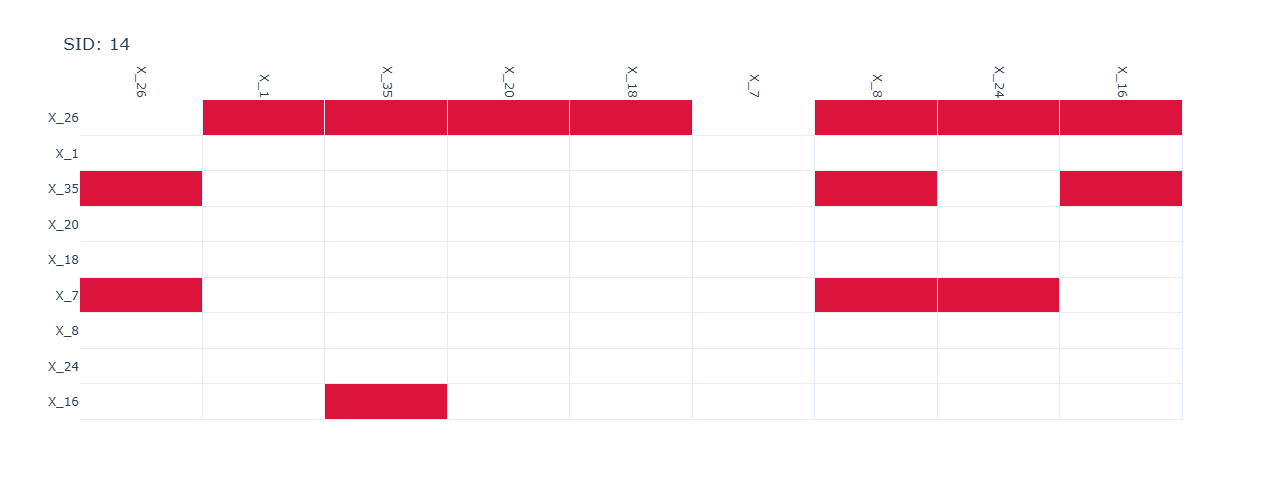

In [74]:
bn_obj.plot_sid_matrix(nodes=nodes)

Interventions on $X_{26}$, $X_{35}$, $X_{16}$ and $X_7$ lead to several incorrect predictions.


### Local SID Evaluation for Multiple Nodes

With the `bnm` package, you can analyze not just a single node, but a list of nodes.  


### 📌 Example: Nodes X_16 and X_35

- **Left**: True Markov blanket of $X_{16}$ and $X_{35}$  
- **Right**: Same set of nodes, with structure from the estimated graph  

In [75]:
nodes = ['X_16', 'X_35']
bn_obj.compare_two_bn(
    nodes=nodes,
    option=2,
    name1='True Markov Blanket of X_16 and X_35',
    name2='Estimated Structure over Same Nodes'
)

$\text{SID} = 52$, highlighting many incorrect interventional predictions

This approach helps:
- Evaluate causal accuracy around multiple variables  
- Identify where interventional errors are concentrated  
- Scale SID diagnostics to subnetworks, not just individual nodes  


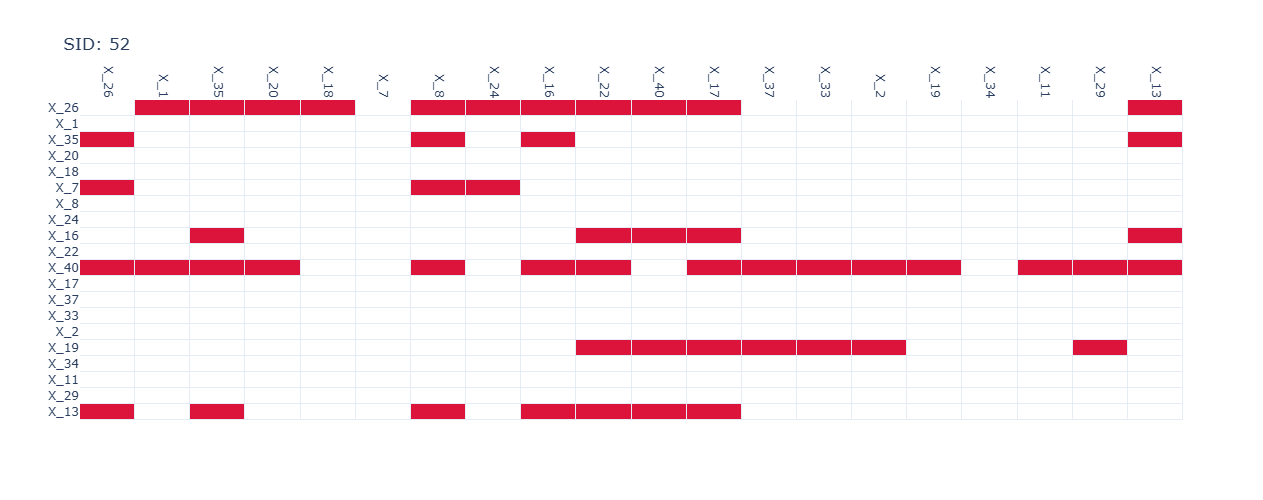

In [76]:
bn_obj.plot_sid_matrix(nodes=nodes)

### Key Takeaways

- This use case shows how SID can be localized, allowing for focused causal validation in subregions of a large graph.
- It is particularly useful when users care about a specific node or set of variables.
- SID heatmaps offer a clear view of which intervention effects are likely to be reliable and which may be compromised due to structural errors.

## Conclusion

In this notebook, we demonstrated the use of the `bnm` package to evaluate causal graphs using the $\text{SID}$. Through three use cases, we showed how SID:

1. Captures interventional differences that traditional metrics like SHD may miss.
2. Provides bounds when comparing DAGs to CPDAGs, helping assess the reliability of partially directed structures.
3. Enables local analysis around specific nodes or subgraphs, identifying exactly which interventions are estimated incorrectly.

We also illustrated how SID matrices and visual comparisons make it easier to:
- Interpret causal errors
- Drill down into specific variables of interest

Overall, `bnm` offers a practical and interpretable framework for validating causal discovery results when interventions matter.
